In [9]:
import sys
import os

import numpy as np 
import matplotlib.pyplot as plt

from src.model import *
from src.dataset import MyDataset, WeakDataset
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from IPython.display import clear_output

from sklearn.linear_model import LinearRegression

from src.utils import (
    set_seed,
    root_dir,
    save_ckpt,
    load_ckpt,
    log_meters,
    plot_losses,
    reset_meters,
    create_meters,
    print_cfg_info,
    load_data_scaler,
)

In [10]:
cfg = {
    "z_dim": 256,
    "gen_dims": [128, 32, 8, 4],
    "disc_dims": [4, 128, 32, 8],
    "num_epochs": 10000,
    "batch_size": 50,
    "w_gp": 10,
    "w_eps": 1e-3,
    "w_weak":1e-3,
    "display_freq": 10,
    "schedule_freq": 2500,
    "seed": 5051,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "from_epoch": 2
}

cgf_model = {
    
}

cfg_dataset = {
    'n_samples_train':100,
    'n_samples_weak':900,
    'n_samples_test':1000,
}

cfg_make_reg = {
    'n_samples':cfg_dataset['n_samples_train']\
                +cfg_dataset['n_samples_weak']\
                +cfg_dataset['n_samples_test'],
    'n_features':20,
    'n_informative':20,
    'n_targets':2,
    'shuffle':False,
    "noise":0,
}

cfg_loader = {  
    "batch_size":cfg["batch_size"],
    "drop_last":False,
}

In [11]:
X, y = make_regression(**cfg_make_reg)
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=cfg_dataset["n_samples_test"])

X_weak = X_train[cfg_dataset["n_samples_train"]:]
X_train = X_train[:cfg_dataset["n_samples_train"]]
y_train = y_train[:cfg_dataset["n_samples_train"]]
train_loader = MyDataset(X_train, y_train, batch_size=cfg["batch_size"], device=cfg["device"])
test_loader = MyDataset(X_test, y_test, batch_size=cfg["batch_size"], device=cfg["device"])
weak_loader = WeakDataset(X_weak, batch_size=cfg["batch_size"], device=cfg["device"])

In [14]:
netG =  nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

netD = nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 1)
).to(cfg["device"])

optimG = Adam(netG.parameters(), lr=1e-3)
optimD = Adam(netD.parameters(), lr=1e-3)

meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
meters = create_meters(meter_names)

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

schedG = torch.optim.lr_scheduler.ExponentialLR(optimG, gamma=0.5)
schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

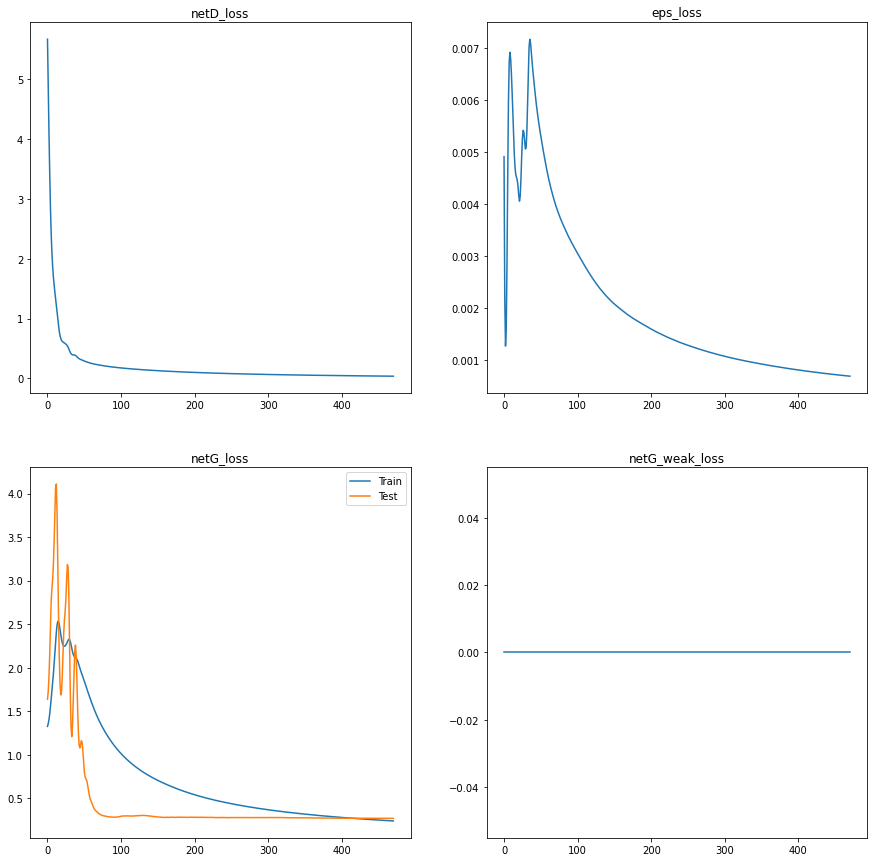

In [ ]:
try:
    losses = [[], [], [], [], []]
    for e in range(cfg['num_epochs']):
        for X_batch, y_batch in train_loader:
            ### Discriminator
            optimD.zero_grad()
            real = torch.cat([X_batch, y_batch], axis=1)
            #
            #X_batch = weak_loader.sample()
            
            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()

            netD_loss = e_fake - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()
            
            ### Generator
            optimG.zero_grad()
            optimD.zero_grad()
            
            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            
#            X_batch_weak = weak_loader.sample()
            
#            with torch.no_grad():
#                noise_weak = torch.cat([X_batch_weak,
#                                    torch.zeros((X_batch_weak.shape[0], y_train.shape[1]), device=cfg['device'])], axis=1)
#                fake_weak = torch.cat([X_batch_weak,
#                                    netG(noise_weak)], axis=1)
#
#            grads = torch.autograd.grad(
#                outputs=netG(fake_weak.requires_grad_(True)).sum(),
#                inputs=fake_weak,
#                create_graph=True,
#                retain_graph=True,
#            )[0]
#
#            grad_loss = (grads**2).sum(axis=1).mean()
#            meters['netG_weak_loss'].update(grad_loss.item())
            
            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())

            netG_loss_total = netG_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            losses[4].append(l2_test)
            plot_losses(losses)       
            
        if not e%cfg["schedule_freq"]:
            schedD.step()
            schedG.step()
            
except KeyboardInterrupt:
    clear_output(wait=True)
    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    losses[4].append(l2_test)
    plot_losses(losses)

In [11]:
netG =  nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

netD = nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
).to(cfg["device"])

optimG = Adam(netG.parameters(), lr=1e-3)
optimD = Adam(netD.parameters(), lr=1e-3)

meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
meters = create_meters(meter_names)

schedG = torch.optim.lr_scheduler.ExponentialLR(optimG, gamma=0.5)
schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

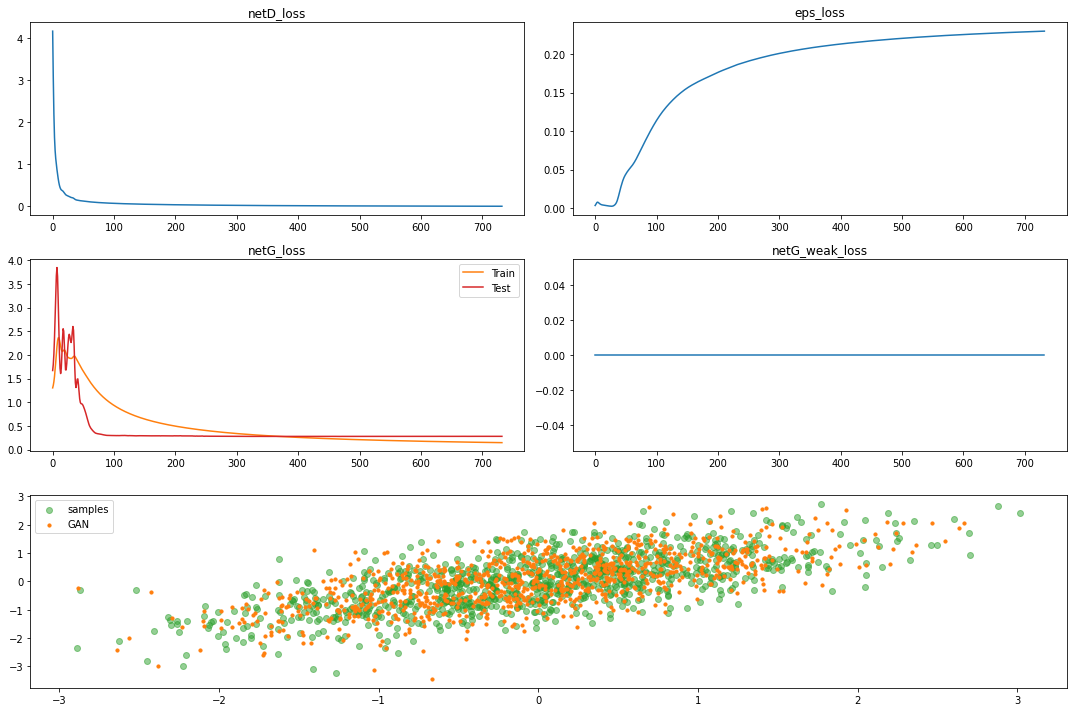

In [ ]:
try:
    losses = [[], [], [], [], []]
    for e in range(cfg['num_epochs']):
        for X_batch, y_batch in train_loader:
            X_batch_weak = weak_loader.sample()

            ### Discriminator
            optimD.zero_grad()
            real = torch.cat([X_batch, y_batch], axis=1)

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)
                
                noise_weak = torch.cat([X_batch_weak,
                                    torch.zeros((X_batch_weak.shape[0], y_train.shape[1]),
                                    device=cfg['device'])], axis=1)
                fake_weak = torch.cat([X_batch_weak,
                                    netG(noise_weak)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()
            e_fake_weak = netD(fake_weak).mean()
            netD_loss = e_fake + e_fake_weak*cfg["w_weak"] - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()
            
            ### Generator
            optimG.zero_grad()
            optimD.zero_grad()
            
            with torch.no_grad():
                noise = torch.cat([X_batch,
                                   torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                              netG(noise)], axis=1)

            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            
            meters['netG_weak_loss'].update(0)
            
            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())

            netG_loss_total = netG_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            losses[4].append(l2_test)
            plot_losses(losses, meters, y_test, y_pred)         
            
        if not e%cfg["schedule_freq"]:
            schedD.step()
            schedG.step()
            
except KeyboardInterrupt:
    clear_output(wait=True)
    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    losses[4].append(l2_test)
    plot_losses(losses, meters, y_test, y_pred)

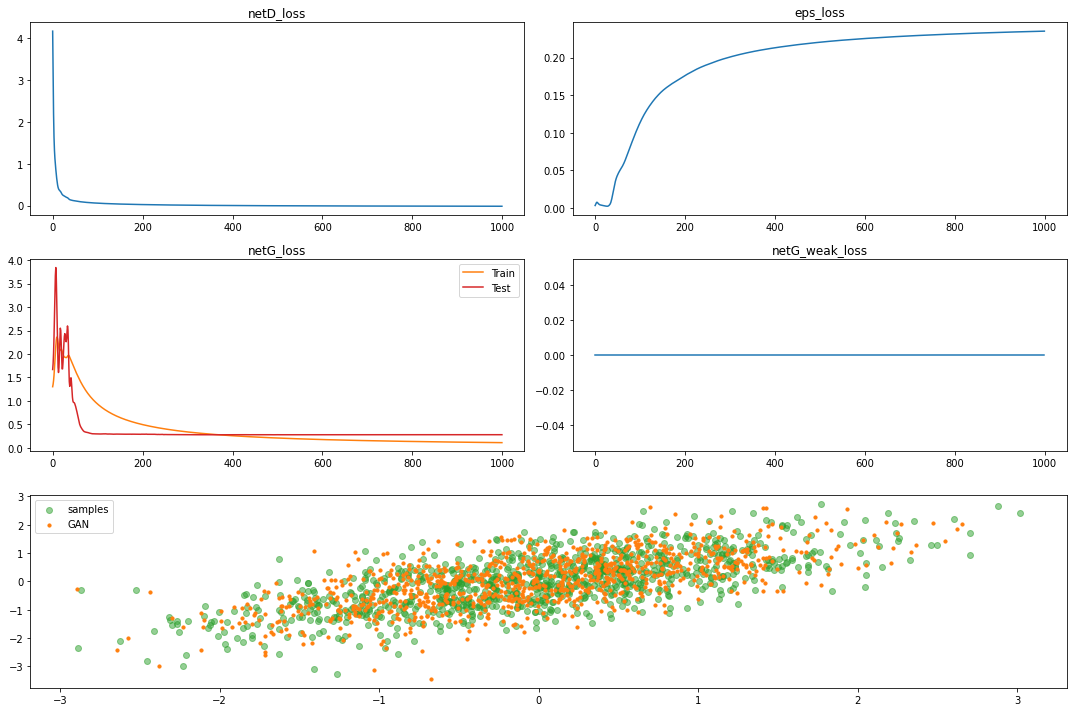

In [22]:
plot_losses(losses_weak_D, meters_weak_D, X_test_torch, y_pred_weak_D)

In [ ]:
netG =  nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

netD = nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
).to(cfg["device"])

optimG = Adam(netG.parameters(), lr=1e-3)
optimD = Adam(netD.parameters(), lr=1e-3)

meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
meters = create_meters(meter_names)

schedG = torch.optim.lr_scheduler.ExponentialLR(optimG, gamma=0.5)
schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

In [ ]:
try:
    losses = [[], [], [], [], []]
    for e in range(cfg['num_epochs']):
        for X_batch, y_batch in train_loader:
            X_batch_weak = weak_loader.sample()

            ### Discriminator
            optimD.zero_grad()
            real = torch.cat([X_batch, y_batch], axis=1)

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)
                
                noise_weak = torch.cat([X_batch_weak,
                                    torch.zeros((X_batch_weak.shape[0], y_train.shape[1]),
                                    device=cfg['device'])], axis=1)
                fake_weak = torch.cat([X_batch_weak,
                                    netG(noise_weak)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()
            e_fake_weak = netD(fake_weak).mean()
            netD_loss = e_fake + e_fake_weak*cfg["w_weak"] - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()
            
            ### Generator
            optimG.zero_grad()
            optimD.zero_grad()
            
            with torch.no_grad():
                noise = torch.cat([X_batch,
                                   torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                              netG(noise)], axis=1)

            fake_weak = torch.cat([X_batch_weak,
                                  netG(noise_weak)], axis=1)
            
            netG_pred = netD(fake) 
            netG_pred_weak = cfg["w_weak"]*netD(fake_weak)
            netG_loss = - (netG_pred.mean() + netG_pred_weak.mean())
            
            meters['netG_weak_loss'].update(0)
            
            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())

            netG_loss_total = netG_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            losses[4].append(l2_test)
            plot_losses(losses, meters, y_test, y_pred)         
            
        if not e%cfg["schedule_freq"]:
            schedD.step()
            schedG.step()
            
except KeyboardInterrupt:
    clear_output(wait=True)
    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    losses[4].append(l2_test)
    plot_losses(losses, meters, y_test, y_pred)

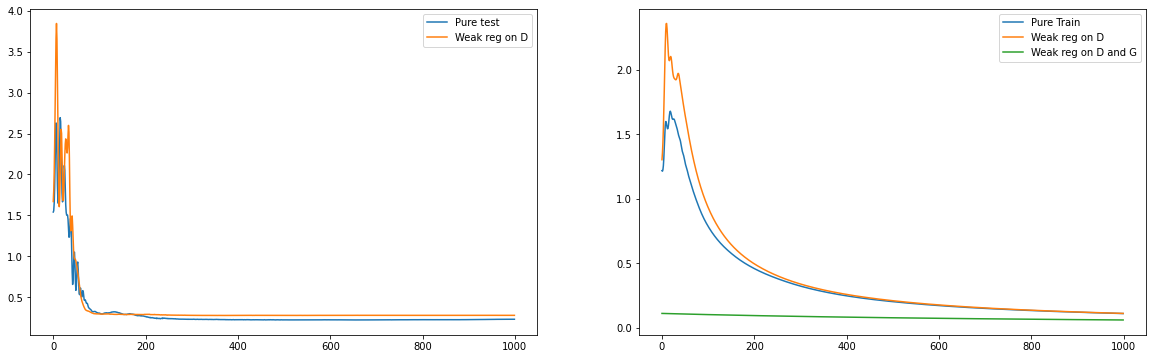

In [41]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 6))
ax1 = axs[0]
ax2 = axs[1]

for points, label in zip([losses_pure, losses_weak_D,], 
             ["Pure test", "Weak reg on D", ]):
    ax1.plot(points[4], label=label)
    
ax1.legend()

for points, label in zip([losses_pure, losses_weak_D, losses_weak_D_G], 
             ["Pure Train", "Weak reg on D", "Weak reg on D and G"]):
    ax2.plot(points[2], label=label)
ax2.legend()

plt.show()

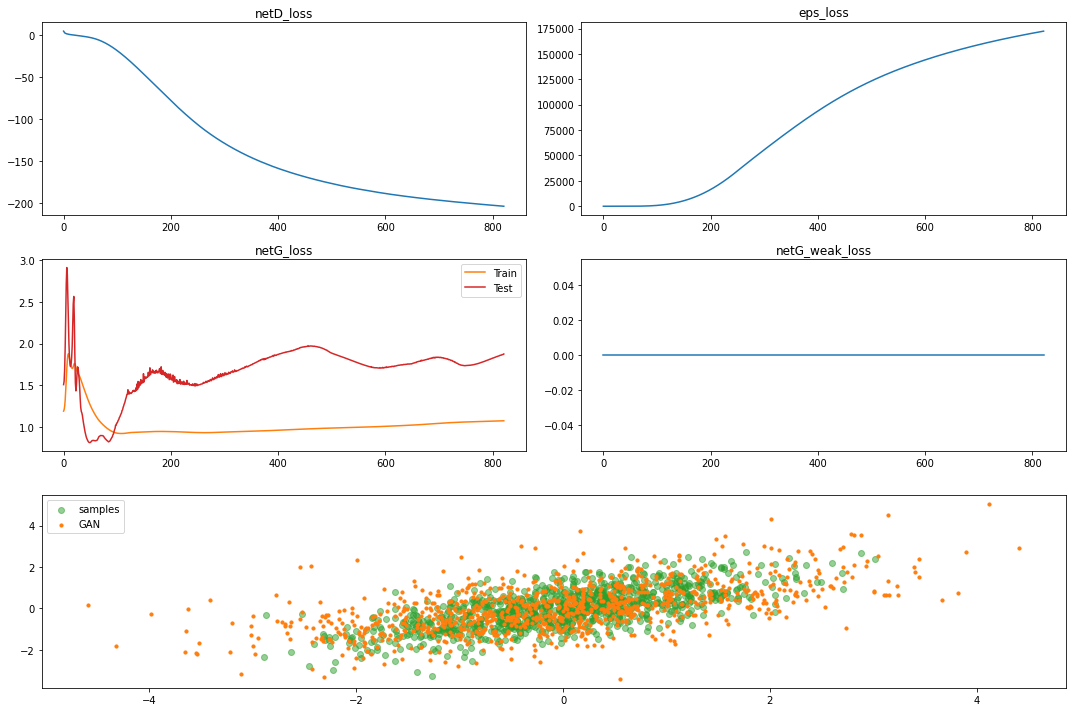

In [ ]:
results = {}

try:
    for eps in [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
        losses = [[], [], [], [], []]
        cfg["w_weak"] = eps
        
        netG =  nn.Sequential(
            nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, y_train.shape[1]),
        ).to(cfg["device"])

        netD = nn.Sequential(
            nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, y_train.shape[1])
        ).to(cfg["device"])

        optimG = Adam(netG.parameters(), lr=1e-3)
        optimD = Adam(netD.parameters(), lr=1e-3)

        meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
        meters = create_meters(meter_names)

        schedG = torch.optim.lr_scheduler.ExponentialLR(optimG, gamma=0.5)
        schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)
        
        for e in range(cfg['num_epochs']):
            for X_batch, y_batch in train_loader:
                X_batch_weak = weak_loader.sample()

                ### Discriminator
                optimD.zero_grad()
                real = torch.cat([X_batch, y_batch], axis=1)

                with torch.no_grad():
                    noise = torch.cat([X_batch,
                                          torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                    fake = torch.cat([X_batch,
                                         netG(noise)], axis=1)

                    noise_weak = torch.cat([X_batch_weak,
                                        torch.zeros((X_batch_weak.shape[0], y_train.shape[1]),
                                        device=cfg['device'])], axis=1)
                    fake_weak = torch.cat([X_batch_weak,
                                        netG(noise_weak)], axis=1)

                e_fake = netD(fake).mean()
                e_real = netD(real).mean()
                e_fake_weak = netD(fake_weak).mean()
                netD_loss = e_fake + e_fake_weak*cfg['w_weak'] - e_real

                meters['netD_real_loss'].update(e_real.item())
                meters['netD_fake_loss'].update(e_fake.item())

                eps_pen = e_real ** 2
                eps_loss = eps_pen.mean()
                meters['eps_loss'].update(eps_loss.item())

                mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
                mixed = mix_alpha * real + (1 - mix_alpha) * fake
                mixed.requires_grad_(True)
                mixed_preds = netD(mixed).sum()
                grads = torch.autograd.grad(
                    outputs=mixed_preds,
                    inputs=mixed,
                    create_graph=True,
                    retain_graph=True,
                )[0]
                grads = grads.view(len(real), -1)
                grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
                meters['grad_loss'].update(grad_loss.item())

                netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
                meters['netD_loss'].update(netD_total_loss.item())
                netD_total_loss.backward()
                optimD.step()

                ### Generator
                optimG.zero_grad()
                optimD.zero_grad()

                with torch.no_grad():
                    noise = torch.cat([X_batch,
                                       torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                  netG(noise)], axis=1)

                fake_weak = torch.cat([X_batch_weak,
                                      netG(noise_weak)], axis=1)

                netG_pred = netD(fake) 
                netG_pred_weak = cfg['w_weak']*netD(fake_weak)
                netG_loss = - (netG_pred.mean() + netG_pred_weak.mean())

                meters['netG_weak_loss'].update(0)

                with torch.no_grad():
                    L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                    meters['netG_loss'].update(L2Loss.item())

                netG_loss_total = netG_loss
                netG_loss_total.backward()
                optimG.step()

            if not e % cfg["display_freq"]:
                clear_output(wait=True)
                with torch.no_grad():
                    noise = torch.cat([X_test_torch,
                                          torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                    y_pred = netG(noise)
                    l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

                losses[0].append(meters["netD_loss"].avg)
                losses[1].append(meters["eps_loss"].avg)
                losses[2].append(meters["netG_loss"].avg)
                losses[3].append(meters["netG_weak_loss"].avg)
                losses[4].append(l2_test)
                plot_losses(losses, meters, y_test, y_pred)         

            if not e%cfg["schedule_freq"]:
                schedD.step()
                schedG.step()
            
        results[eps] = (losses, meters, y_pred)

except KeyboardInterrupt:
    clear_output(wait=True)
    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    losses[4].append(l2_test)
    plot_losses(losses, meters, y_test, y_pred)

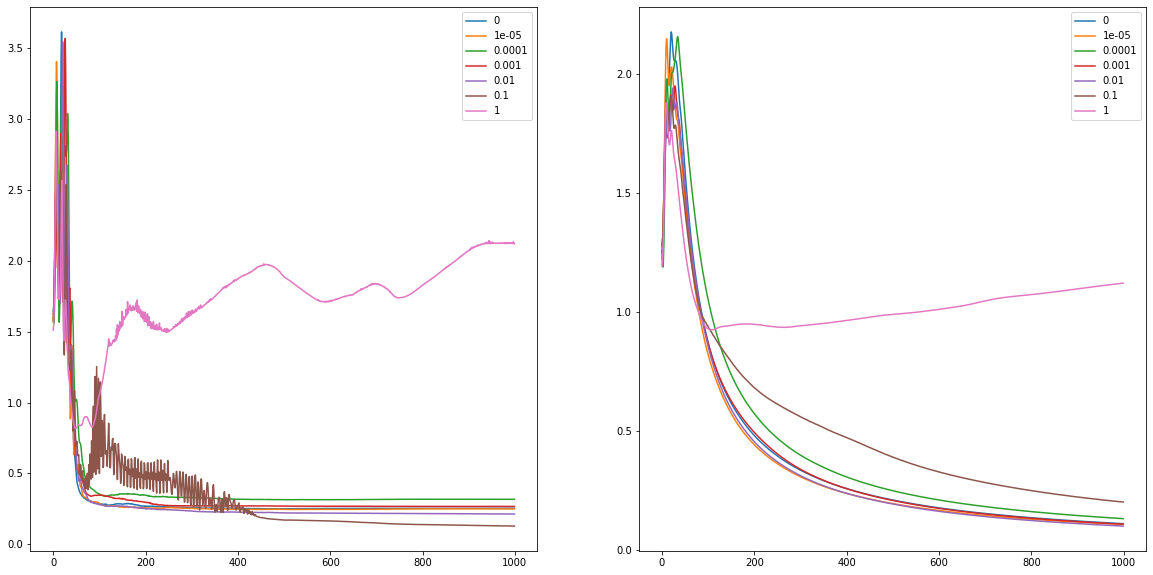

In [56]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
ax1 = axs[0]
ax2 = axs[1]

for eps, points in results.items():
    ax1.plot(points[0][4], label=eps)
    
ax1.legend()

for eps, points in results.items():
    ax2.plot(points[0][2], label=eps)
ax2.legend()
plt.show()

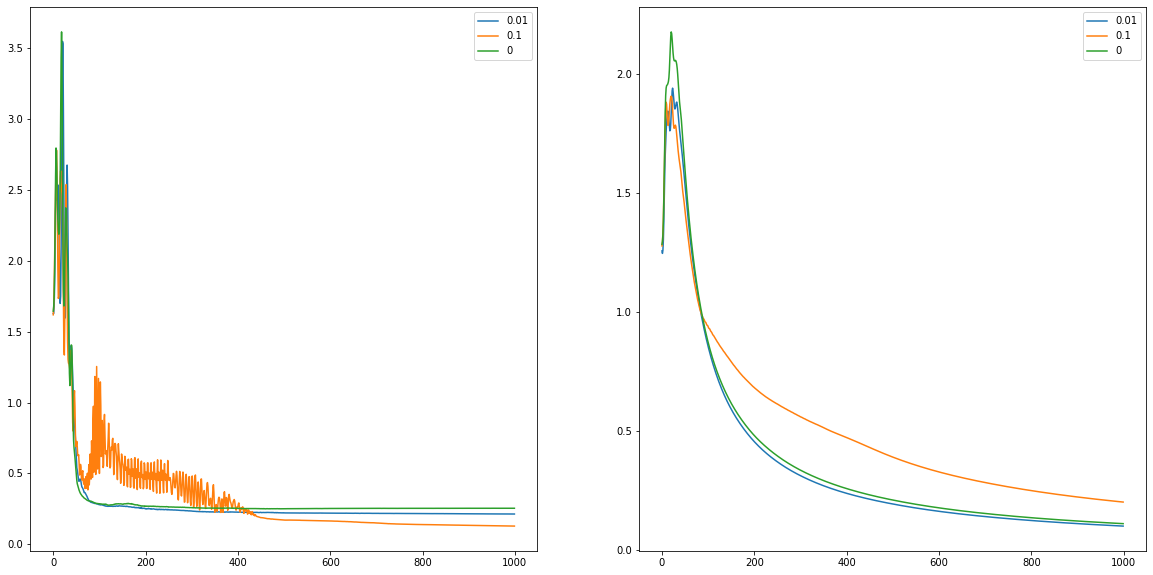

In [57]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(results[0.01][0][4], label=0.01)
ax1.plot(results[0.1][0][4], label=0.1)
ax1.plot(results[0][0][4], label=0)
    
ax1.legend()

ax2.plot(results[0.01][0][2], label=0.01)
ax2.plot(results[0.1][0][2], label=0.1)
ax2.plot(results[0][0][2], label=0)
    
ax2.legend()
plt.show()

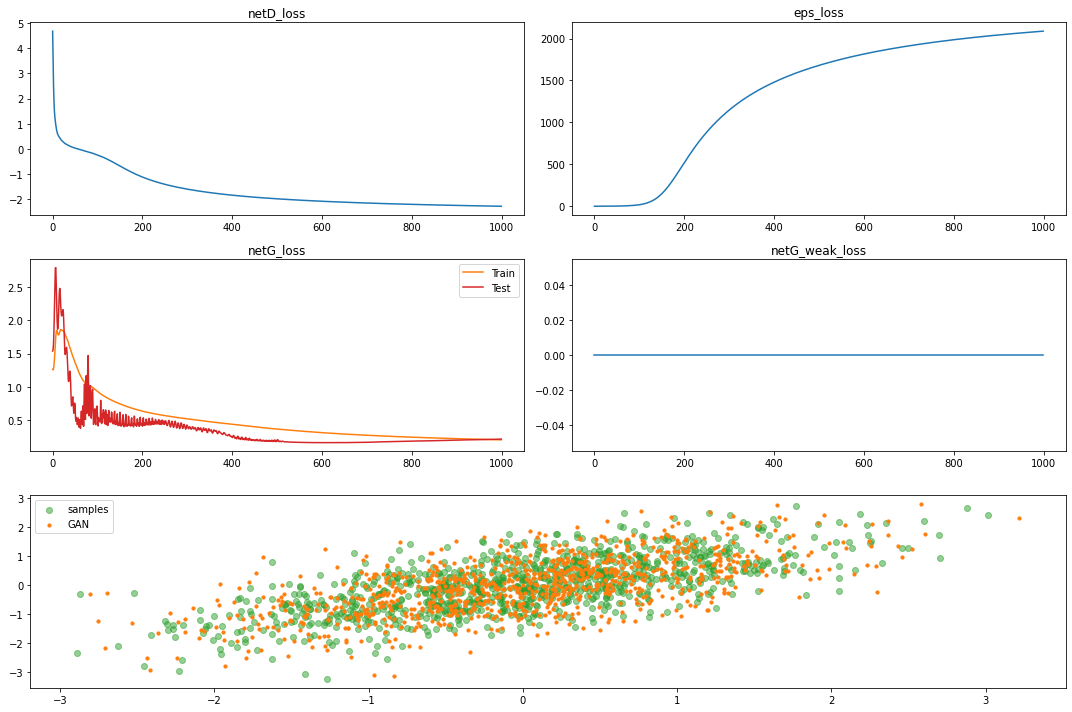

In [58]:
try:
    losses = [[], [], [], [], []]
    cfg["w_weak"] = 0.1

    netG =  nn.Sequential(
        nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    netD = nn.Sequential(
        nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1])
    ).to(cfg["device"])

    optimG = Adam(netG.parameters(), lr=1e-3)
    optimD = Adam(netD.parameters(), lr=1e-3)

    meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
    meters = create_meters(meter_names)

    schedG = torch.optim.lr_scheduler.ExponentialLR(optimG, gamma=0.5)
    schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

    for e in range(cfg['num_epochs']):
        for X_batch, y_batch in train_loader:
            X_batch_weak = weak_loader.sample()

            ### Discriminator
            optimD.zero_grad()
            real = torch.cat([X_batch, y_batch], axis=1)

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

                noise_weak = torch.cat([X_batch_weak,
                                    torch.zeros((X_batch_weak.shape[0], y_train.shape[1]),
                                    device=cfg['device'])], axis=1)
                fake_weak = torch.cat([X_batch_weak,
                                    netG(noise_weak)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()
            e_fake_weak = netD(fake_weak).mean()
            netD_loss = e_fake + e_fake_weak*cfg['w_weak'] - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()

            ### Generator
            optimG.zero_grad()
            optimD.zero_grad()

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                   torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                              netG(noise)], axis=1)

            fake_weak = torch.cat([X_batch_weak,
                                  netG(noise_weak)], axis=1)

            netG_pred = netD(fake) 
            netG_pred_weak = cfg['w_weak']*netD(fake_weak)
            netG_loss = - (netG_pred.mean() + netG_pred_weak.mean())

            meters['netG_weak_loss'].update(0)

            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())

            netG_loss_total = netG_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            losses[4].append(l2_test)
            plot_losses(losses, meters, y_test, y_pred)         

        if not e%cfg["schedule_freq"]:
            schedD.step()
            schedG.step()

except KeyboardInterrupt:
    clear_output(wait=True)
    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    losses[4].append(l2_test)
    plot_losses(losses, meters, y_test, y_pred)

In [17]:
weak_loader = WeakDataset(X_weak, batch_size=cfg["batch_size"]*18, device=cfg["device"])

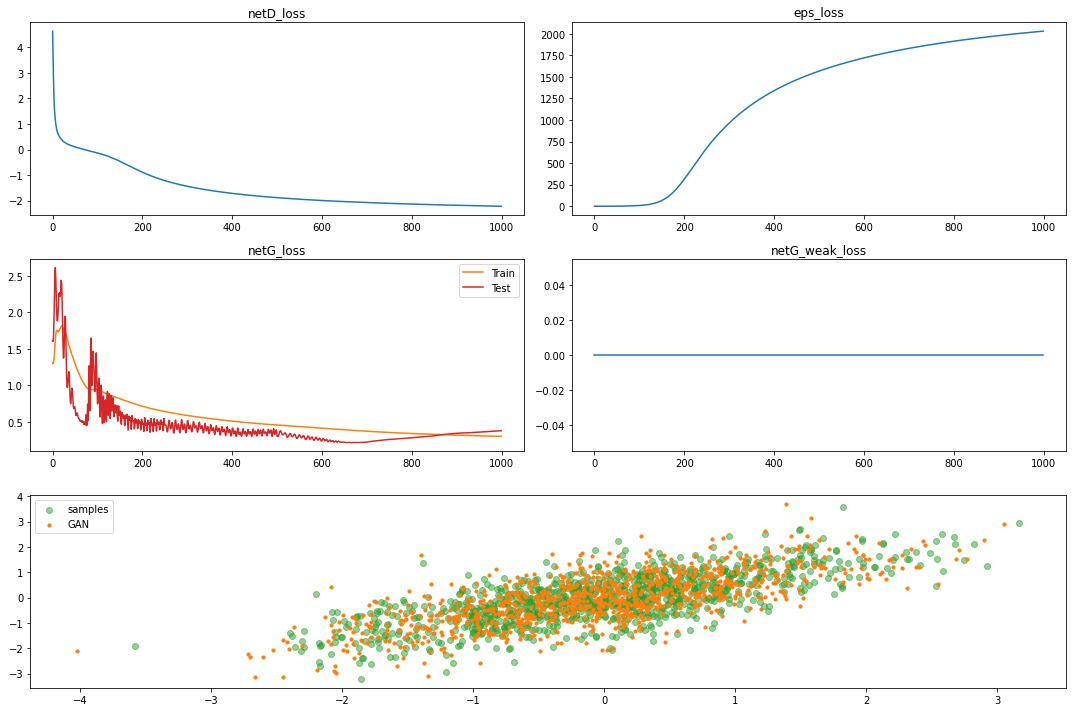

In [18]:
try:
    losses = [[], [], [], [], []]
    cfg["w_weak"] = 0.1

    netG =  nn.Sequential(
        nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1]),
    ).to(cfg["device"])

    netD = nn.Sequential(
        nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
        nn.ReLU(),
        nn.Linear(64, y_train.shape[1])
    ).to(cfg["device"])

    optimG = Adam(netG.parameters(), lr=1e-3)
    optimD = Adam(netD.parameters(), lr=1e-3)

    meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
    meters = create_meters(meter_names)

    schedG = torch.optim.lr_scheduler.ExponentialLR(optimG, gamma=0.5)
    schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

    for e in range(cfg['num_epochs']):
        for X_batch, y_batch in train_loader:
            X_batch_weak = weak_loader.sample()

            ### Discriminator
            optimD.zero_grad()
            real = torch.cat([X_batch, y_batch], axis=1)

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)[:cfg["batch_size"]]
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

                noise_weak = torch.cat([X_batch_weak,
                                    torch.zeros((X_batch_weak.shape[0], y_train.shape[1]),
                                    device=cfg['device'])], axis=1)
                fake_weak = torch.cat([X_batch_weak,
                                    netG(noise_weak)], axis=1)

            
            e_fake = netD(fake[:cfg["batch_size"]]).mean()
            e_real = netD(real).mean()
            e_fake_weak = netD(fake_weak).mean()
            netD_loss = e_fake + e_fake_weak*cfg['w_weak'] - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()

            ### Generator
            optimG.zero_grad()
            optimD.zero_grad()

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                   torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                              netG(noise)], axis=1)

            fake_weak = torch.cat([X_batch_weak,
                                  netG(noise_weak)], axis=1)

            netG_pred = netD(fake) 
            netG_pred_weak = cfg['w_weak']*netD(fake_weak)
            netG_loss = - (netG_pred.mean() + netG_pred_weak.mean())

            meters['netG_weak_loss'].update(0)

            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())

            netG_loss_total = netG_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            losses[4].append(l2_test)
            plot_losses(losses, meters, y_test, y_pred)         

        if not e%cfg["schedule_freq"]:
            schedD.step()
            schedG.step()

except KeyboardInterrupt:
    clear_output(wait=True)
    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    losses[4].append(l2_test)
    plot_losses(losses, meters, y_test, y_pred)

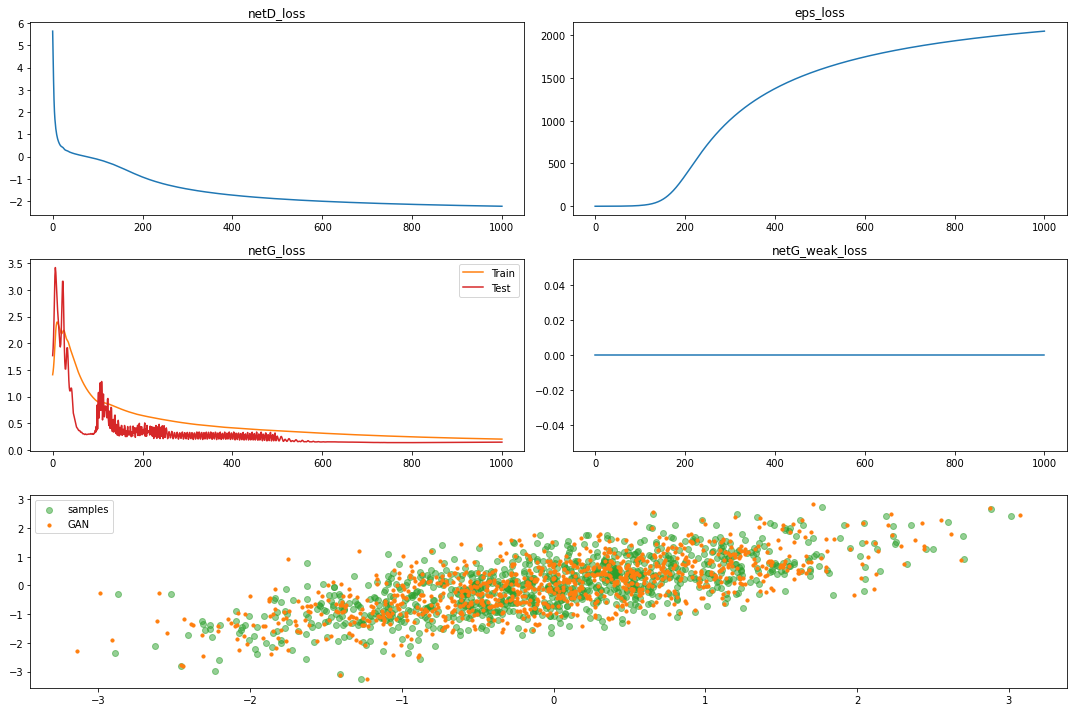

In [76]:
    clear_output(wait=True)
    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    losses[4].append(l2_test)
    plot_losses(losses, meters, y_test, y_pred)